In [1]:
from astropy.io import fits
import os
import shutil
from astropy.timeseries import LombScargle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import optimize
from scipy.interpolate import CubicSpline
from scipy.integrate import simps
from scipy.interpolate import UnivariateSpline
from scipy.ndimage import gaussian_filter
import scipy.signal as signal
from astropy.time import Time
import pandas as pd
from lmfit import Model
from scipy.optimize import curve_fit
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from scipy.ndimage.filters import uniform_filter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from sklearn.metrics import mean_squared_error

In [2]:
def straightLine(xpoints,ypoints,inXpoints):
    gradient = (ypoints[1]-ypoints[0])/(xpoints[1]-xpoints[0])
    intercept = ypoints[0] - (gradient*xpoints[0])
    outYpoints = (inXpoints*gradient)+intercept
    return outYpoints
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def area_est(xpoints, ypoints, start, finish):
    
    startIdx = find_nearest(xpoints, start)
    finishIdx = find_nearest(xpoints, finish)
    xpoints = xpoints[startIdx:finishIdx]
    ypoints = ypoints[startIdx:finishIdx]
    areaEst = np.trapz(ypoints, x=xpoints)
    return areaEst
xpoints=np.linspace(0,4200,4200)
def median_average(array, N):
    result = []
    for i in range(0, int(np.shape(array)[0]/N)+1):
        tmparray = array[i*N:(i*N+N)]
        tmparray = np.median(tmparray,axis=0)
        if i == 0:
            result = tmparray
            
        else:
            result = np.vstack([result, tmparray])
            
    return result


def fCubic(x, c, q,A, B): 
    #previously f
    return c*x*x*x + q*x*x + A*x + B

def fQuart(x, d,c, q,A, B): 
    return d*x*x*x*x + c*x*x*x + q*x*x + A*x + B
def fQuad(x, c, q,A): 
    return c*x*x + q*x + A

def fFive(x, c, q,A,b,d,z): 
    return c*x*x*x*x*x + q*x*x*x*x + A*x*x*x + b*x*x + d*x+z

def foldMeth(timeArray, period):
    phases = []
    for el in timeArray:
        passed = int(el/period)
        leftover = el - (passed*period)
        phase = leftover/period
        phases.append(phase)
    return np.array(phases)

def SNREst(fluxVal):
    signal = np.median(fluxVal)
    errors = []
    for el in fluxVal:
        error = np.abs(el-signal)
        errors.append(error)
    return signal/np.mean(errors)
def EWUn(N, dw, SNR, countsEm, countsCont, lenCont):
    r = (countsEm/ countsCont)
    return ((N*dw*dw)/(SNR*SNR))*(r/lenCont)*(r+lenCont)

In [3]:
fff = open("timeBM", "r")
timeBM = []
for x in fff:
    x = float(x)
    timeBM.append(x)
    
fff = open("timeRM", "r")
timeRM = []
for x in fff:
    x = float(x)
    timeRM.append(x)
    
fff = open("timeBJ", "r")
timeBJ = []
for x in fff:
    x = float(x)
    timeBJ.append(x)
    
fff = open("timeRJ", "r")
timeRJ = []
for x in fff:
    x = float(x)
    timeRJ.append(x)
    
BJXpoints = np.linspace(3625, 5460, 4200)

RJXpoints = np.linspace(5525, 7575, 4200)

countGlob = 1
holder_arrayBM = []

path = 'C:/Users/Admin/newMay19/'
consts = []
with open(path+'BTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayBM = typeEx
        else:
            
            holder_arrayBM = np.vstack((holder_arrayBM, typeEx))
        countGlob = 2
countGlob = 1
holder_arrayBJ = []

path = 'C:/Users/Admin/newJul18/'
consts = []
with open(path+'BTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayBJ = typeEx
        else:
            
            holder_arrayBJ = np.vstack((holder_arrayBJ, typeEx))
        countGlob = 2
        
countGlob = 1
holder_arrayRJ = []

path = 'C:/Users/Admin/newJul18/'
consts = []
with open(path+'RTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
  
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayRJ = typeEx
        else:
            
            holder_arrayRJ = np.vstack((holder_arrayRJ, typeEx))
        countGlob = 2

countGlob = 1
holder_arrayRM = []

path = 'C:/Users/Admin/newMay19/'
consts = []
with open(path+'RTarOutDis') as file:
    for line in file:
        line = line.strip('\n')
        filepath = path + line
        hdul = fits.open(filepath)
        typeEx = hdul[0].data
        typeEx = typeEx[1]
        typeEx = typeEx.flatten()

        hdul.close()
        if countGlob == 1:
            
            holder_arrayRM = typeEx
        else:
            
            holder_arrayRM = np.vstack((holder_arrayRM, typeEx))
        countGlob = 2

RSM = [6287.706,6361.843]

RPi = [6510.116,6608.965]

RSP = [6707.814,6846.202]

BSM = [4621.838,4740.841]

BPi = [4782.842,4859.842]

BSP = [4912.343,4954.345]

In [4]:
RJXpoints[1]-RJXpoints[0]

0.4882114789234038

In [5]:
print(find_nearest(RJXpoints[800:3350],6707.814))
print(find_nearest(RJXpoints[800:3350],6846.202))

1623
1906


In [5]:
xpointss[502:731]

array([4499.89164087, 4500.32864968, 4500.76565849, 4501.2026673 ,
       4501.63967611, 4502.07668492, 4502.51369374, 4502.95070255,
       4503.38771136, 4503.82472017, 4504.26172898, 4504.69873779,
       4505.13574661, 4505.57275542, 4506.00976423, 4506.44677304,
       4506.88378185, 4507.32079066, 4507.75779948, 4508.19480829,
       4508.6318171 , 4509.06882591, 4509.50583472, 4509.94284353,
       4510.37985235, 4510.81686116, 4511.25386997, 4511.69087878,
       4512.12788759, 4512.5648964 , 4513.00190522, 4513.43891403,
       4513.87592284, 4514.31293165, 4514.74994046, 4515.18694927,
       4515.62395809, 4516.0609669 , 4516.49797571, 4516.93498452,
       4517.37199333, 4517.80900214, 4518.24601095, 4518.68301977,
       4519.12002858, 4519.55703739, 4519.9940462 , 4520.43105501,
       4520.86806382, 4521.30507264, 4521.74208145, 4522.17909026,
       4522.61609907, 4523.05310788, 4523.49011669, 4523.92712551,
       4524.36413432, 4524.80114313, 4525.23815194, 4525.67516

In [6]:
#individual
xpointss = BJXpoints[1500:3800]
xp1 = xpointss[0:35]
xp2 = xpointss[125:800]
xp3 = xpointss[1100:1180]
xp4 = xpointss[1330:1440]
xp5 = xpointss[1550:2400]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
testMean = np.zeros(len(xpointss))
BJSM = []
BJSMErrors = []
BJPi = []
BJPiErrors = []
BJSP = []
BJSPErrors = []
dw = BJXpoints[1501]-BJXpoints[1500]
dwB = dw
testMorph = []
testMorpErr = []
SNRsBJ = []
for i in range(113):
    flux = holder_arrayBJ[i]
    flux = flux[1500:3800]
    tmp1 = flux[0:35]
    tmp2 = flux[125:800]
    tmp3 = flux[1100:1180]
    tmp4 = flux[1330:1440]
    tmp5 = flux[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fCubic, xpF, emptiedflux)
    fluxNormed = flux/fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    for count, el in enumerate(fluxNormed):
        if el > 1.2:
            fluxNormed[count] = np.median(fluxNormed[count-100:count+100])
    fluxNormed = fluxNormed * fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    tmp1 = fluxNormed[0:35]
    tmp2 = fluxNormed[125:800]
    tmp3 = fluxNormed[1100:1180]
    tmp4 = fluxNormed[1330:1440]
    tmp5 = fluxNormed[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fCubic, xpF, emptiedflux)
    fluxNormed = fluxNormed/fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    testMean = testMean + fluxNormed
    BJSM.append(area_est(np.linspace(0,271,272), fluxNormed[781:1053], 0, 271)-area_est(np.linspace(0,271,272), np.ones_like(fluxNormed[781:1053]), 0, 271))
    thisSNR = SNREst(fluxNormed[502:731])
    SNRsBJ.append(np.mean(fluxNormed[502:731])/np.std(fluxNormed[502:731]))
    thisEWUn = EWUn(272, dw, thisSNR, np.mean(fluxNormed[781:1053]), np.median(fluxNormed[502:731]),len(fluxNormed[502:731]))
    BJSMErrors.append(np.sqrt(thisEWUn))

    BJPi.append(area_est(np.linspace(0,216,217), fluxNormed[1129:1346], 0, 216)-area_est(np.linspace(0,216,217), np.ones_like(fluxNormed[1129:1346]), 0, 216))
    thisEWUn = EWUn(217, dw, thisSNR, np.mean(fluxNormed[1129:1346]), np.median(fluxNormed[502:731]),len(fluxNormed[502:731]))
    BJPiErrors.append(np.sqrt(thisEWUn))
    
    BJSP.append(area_est(np.linspace(0,95,96), fluxNormed[1446:1542], 0, 95)-area_est(np.linspace(0,95,96), np.ones_like(fluxNormed[1446:1542]), 0, 95))
    thisEWUn = EWUn(96, dw, thisSNR, np.mean(fluxNormed[1446:1542]), np.median(fluxNormed[502:731]),len(fluxNormed[502:731]))
    BJSPErrors.append(np.sqrt(thisEWUn))
    
    

    testMorph.append(area_est(np.linspace(0,49,50), fluxNormed[1240:1290], 0, 49)-area_est(np.linspace(0,49,50), np.ones_like(fluxNormed[1240:1290]), 0, 49))
    thisEWUn = EWUn(50, dw, thisSNR, np.mean(fluxNormed[1240:1290]), np.median(fluxNormed[502:731]),len(fluxNormed[502:731]))
    testMorpErr.append(np.sqrt(thisEWUn))
    
    if i == 0:
        stack = fluxNormed[800:1600]
    else:
        stack = np.vstack((stack, fluxNormed[800:1600]))
testMean = testMean /113
stackBJ = stack
testMeanBJ = testMean


D:\conda\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\conda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
#combined
xpointss = BJXpoints[1500:3800]
xp1 = xpointss[0:35]
xp2 = xpointss[125:800]
xp3 = xpointss[1100:1180]
xp4 = xpointss[1330:1440]
xp5 = xpointss[1550:2400]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
testMean = np.zeros(len(xpointss))
BJThree = []
BJThreeErrors = []
dw = BJXpoints[1501]-BJXpoints[1500]
dwB = dw
for i in range(113):
    flux = holder_arrayBJ[i]
    flux = flux[1500:3800]
    tmp1 = flux[0:35]
    tmp2 = flux[125:800]
    tmp3 = flux[1100:1180]
    tmp4 = flux[1330:1440]
    tmp5 = flux[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fCubic, xpF, emptiedflux)
    fluxNormed = flux/fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    for count, el in enumerate(fluxNormed):
        if el > 1.2:
            fluxNormed[count] = np.median(fluxNormed[count-100:count+100])
    fluxNormed = fluxNormed * fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    tmp1 = fluxNormed[0:35]
    tmp2 = fluxNormed[125:800]
    tmp3 = fluxNormed[1100:1180]
    tmp4 = fluxNormed[1330:1440]
    tmp5 = fluxNormed[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fCubic, xpF, emptiedflux)
    fluxNormed = fluxNormed/fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    testMean = testMean + fluxNormed
    
    
    
    
    BJThree.append(area_est(np.linspace(0,768,769), fluxNormed[781:1550], 0, 768)-area_est(np.linspace(0,768,769), np.ones_like(fluxNormed[781:1550]), 0, 768))
    thisEWUn = EWUn(769, dw, thisSNR, np.mean(fluxNormed[781:1550]), np.median(fluxNormed[502:731]),len(fluxNormed[502:731]))
    BJThreeErrors.append(np.sqrt(thisEWUn))
    if i == 0:
        stack = fluxNormed[800:1600]
    else:
        stack = np.vstack((stack, fluxNormed[800:1600]))
testMean = testMean /113
stackBJ = stack
testMeanBJ = testMean


50

In [7]:
np.mean(SNRsBJ)

22.33252090301781

In [25]:
BJXpoints[1500+1240]

4822.4041438437725

In [26]:
BJXpoints[1500+1290]

4844.254584424863

In [42]:
dwB

0.43700881162203586

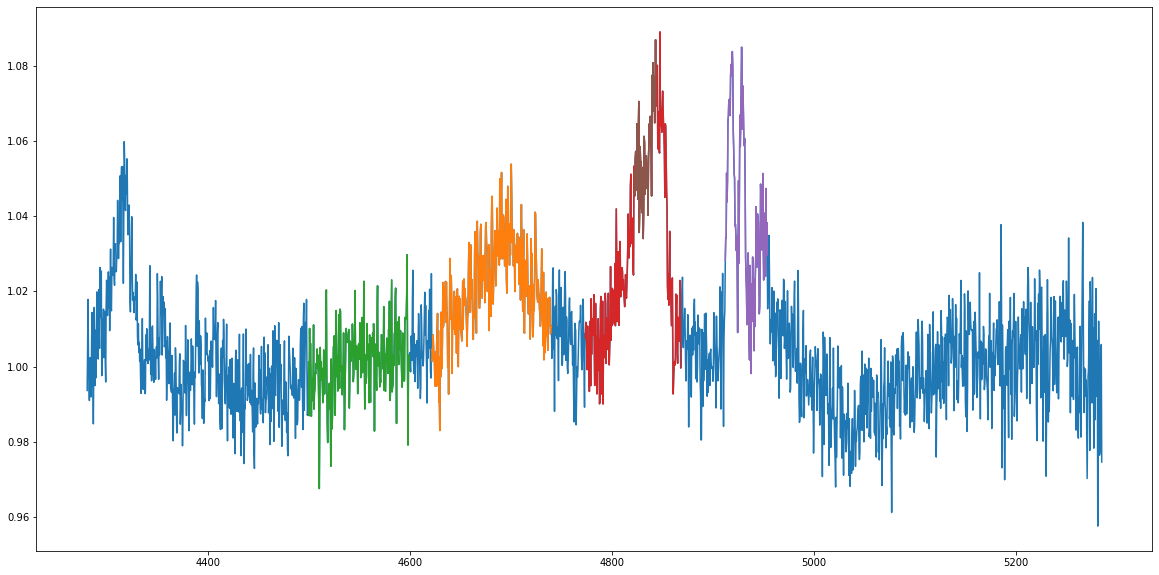

In [8]:
plt.figure(figsize=(20,10))
plt.plot(BJXpoints[1500:3800], testMeanBJ)
plt.plot(BJXpoints[1500+781:1500+1053], testMeanBJ[781:1053])
plt.plot(BJXpoints[1500+502:1500+731], testMeanBJ[502:731])
plt.plot(BJXpoints[1500+1129:1500+1346], testMeanBJ[1129:1346])
plt.plot(BJXpoints[1500+1446:1500+1542], testMeanBJ[1446:1542])
#plt.plot(BJXpoints[1500+1446:1500+1550], testMeanBJ[1446:1550])
plt.plot(BJXpoints[1500+1240:1500+1290], testMeanBJ[1240:1290])

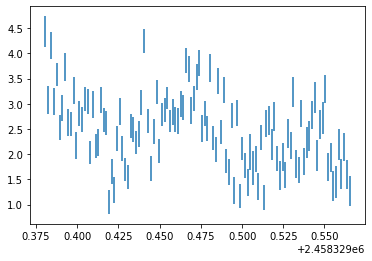

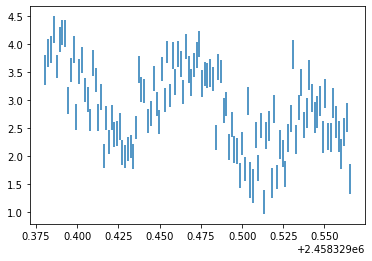

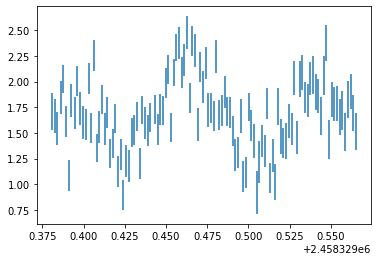

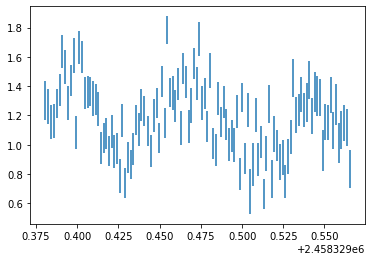

<ErrorbarContainer object of 3 artists>

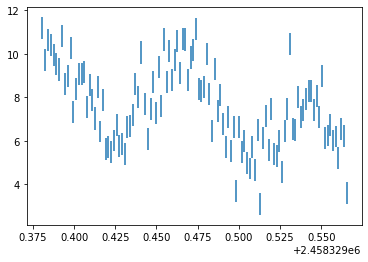

In [10]:
plt.errorbar(timeBJ, np.array(BJSM)*dw, yerr=BJSMErrors, ls='')
#plt.errorbar(timeBJ, (np.array(BJSM)*dw/np.mean(np.array(BJSM)*dw))-1, yerr=BJSMErrors/np.mean(np.array(BJSM)*dw), ls='')
plt.show()
plt.errorbar(timeBJ, np.array(BJPi)*dw, yerr=BJPiErrors, ls='')
plt.show()
plt.errorbar(timeBJ, np.array(BJSP)*dw, yerr=BJSPErrors, ls='')
plt.show()
plt.errorbar(timeBJ, np.array(testMorph)*dw, yerr=testMorpErr, ls='')
dwJ = dw
plt.show()
plt.errorbar(timeBJ, np.array(BJThree)*dw, yerr=BJThreeErrors, ls='')

In [12]:
#together
xpointss = BJXpoints[1500:3800]
xp1 = xpointss[0:35]
xp2 = xpointss[125:800]
xp3 = xpointss[1100:1180]
xp4 = xpointss[1330:1440]
xp5 = xpointss[1550:2400]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
testMean = np.zeros(len(xpointss))
BMThree = []
BMThreeErrors = []
dw = BJXpoints[1501]-BJXpoints[1500]
for i in range(120):
    flux = holder_arrayBM[i]
    flux = flux[1500:3800]
    tmp1 = flux[0:35]
    tmp2 = flux[125:800]
    tmp3 = flux[1100:1180]
    tmp4 = flux[1330:1440]
    tmp5 = flux[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fCubic, xpF, emptiedflux)
    fluxNormed = flux/fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    for count, el in enumerate(fluxNormed):
        if el > 1.2:
            fluxNormed[count] = np.median(fluxNormed[count-100:count+100])
    fluxNormed = fluxNormed * fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    tmp1 = fluxNormed[0:35]
    tmp2 = fluxNormed[125:800]
    tmp3 = fluxNormed[1100:1180]
    tmp4 = fluxNormed[1330:1440]
    tmp5 = fluxNormed[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    emptiedflux = np.nan_to_num(emptiedflux)
    popt, pcov = curve_fit(fCubic, xpF, emptiedflux)
    fluxNormed = fluxNormed/fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    testMean = testMean + fluxNormed
    BMThree.append(area_est(np.linspace(0,768,769), fluxNormed[781:1550], 0, 768)-area_est(np.linspace(0,768,769), np.ones_like(fluxNormed[781:1550]), 0, 768))
    thisEWUn = EWUn(769, dw, thisSNR, np.mean(fluxNormed[781:1550]), np.median(fluxNormed[502:731]),len(fluxNormed[502:731]))
    BMThreeErrors.append(np.sqrt(thisEWUn))
    
    if i == 0:
        stack = fluxNormed[800:1600]
    else:
        stack = np.vstack((stack, fluxNormed[800:1600]))
testMean = testMean /120
stackBM = stack
testMeanBM = testMean


In [50]:
#individual
xpointss = BJXpoints[1500:3800]
xp1 = xpointss[0:35]
xp2 = xpointss[125:800]
xp3 = xpointss[1100:1180]
xp4 = xpointss[1330:1440]
xp5 = xpointss[1550:2400]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
testMean = np.zeros(len(xpointss))
BMSM = []
SNRsBM = []
BMSMErrors = []
BMPi = []
BMPiErrors = []
BMSP = []
BMSPErrors = []
testMorphM = []
testMorphErrM = []
dw = BJXpoints[1501]-BJXpoints[1500]
for i in range(120):
    flux = holder_arrayBM[i]
    flux = flux[1500:3800]
    tmp1 = flux[0:35]
    tmp2 = flux[125:800]
    tmp3 = flux[1100:1180]
    tmp4 = flux[1330:1440]
    tmp5 = flux[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fCubic, xpF, emptiedflux)
    fluxNormed = flux/fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    for count, el in enumerate(fluxNormed):
        if el > 1.2:
            fluxNormed[count] = np.median(fluxNormed[count-100:count+100])
    fluxNormed = fluxNormed * fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    tmp1 = fluxNormed[0:35]
    tmp2 = fluxNormed[125:800]
    tmp3 = fluxNormed[1100:1180]
    tmp4 = fluxNormed[1330:1440]
    tmp5 = fluxNormed[1550:2400]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    emptiedflux = np.nan_to_num(emptiedflux)
    popt, pcov = curve_fit(fCubic, xpF, emptiedflux)
    fluxNormed = fluxNormed/fCubic(xpointss, popt[0], popt[1], popt[2], popt[3])
    testMean = testMean + fluxNormed
    BMSM.append(area_est(np.linspace(0,271,272), fluxNormed[781:1053], 0, 271)-area_est(np.linspace(0,271,272), np.ones_like(fluxNormed[781:1053]), 0, 271))
    thisSNR = SNREst(fluxNormed[502:731])
    SNRsBM.append(np.mean(fluxNormed[502:731])/np.std(fluxNormed[502:731]))
    thisEWUn = EWUn(272, dw, thisSNR, np.mean(fluxNormed[781:1053]), np.median(fluxNormed[502:731]),len(fluxNormed[502:731]))
    BMSMErrors.append(np.sqrt(thisEWUn))

    BMPi.append(area_est(np.linspace(0,176,177), fluxNormed[1149:1326], 0, 176)-area_est(np.linspace(0,176,177), np.ones_like(fluxNormed[1149:1326]), 0, 176))
    thisEWUn = EWUn(177, dw, thisSNR, np.mean(fluxNormed[1149:1326]), np.median(fluxNormed[502:731]),len(fluxNormed[502:731]))
    BMPiErrors.append(np.sqrt(thisEWUn))
    
    BMSP.append(area_est(np.linspace(0,95,96), fluxNormed[1446:1542], 0, 95)-area_est(np.linspace(0,95,96), np.ones_like(fluxNormed[1446:1542]), 0, 95))
    thisEWUn = EWUn(96, dw, thisSNR, np.mean(fluxNormed[1446:1542]), np.median(fluxNormed[502:731]),len(fluxNormed[502:731]))
    BMSPErrors.append(np.sqrt(thisEWUn))
    
    testMorphM.append(area_est(np.linspace(0,49,50), fluxNormed[1240:1290], 0, 49)-area_est(np.linspace(0,49,50), np.ones_like(fluxNormed[1240:1290]), 0, 49))
    thisEWUn = EWUn(50, dw, thisSNR, np.mean(fluxNormed[1240:1290]), np.median(fluxNormed[502:731]),len(fluxNormed[502:731]))
    testMorphErrM.append(np.sqrt(thisEWUn))
    
    if i == 0:
        stack = fluxNormed[800:1600]
    else:
        stack = np.vstack((stack, fluxNormed[800:1600]))
testMean = testMean /120
stackBM = stack
testMeanBM = testMean


In [11]:
np.mean(SNRsBM)

16.510119998324562

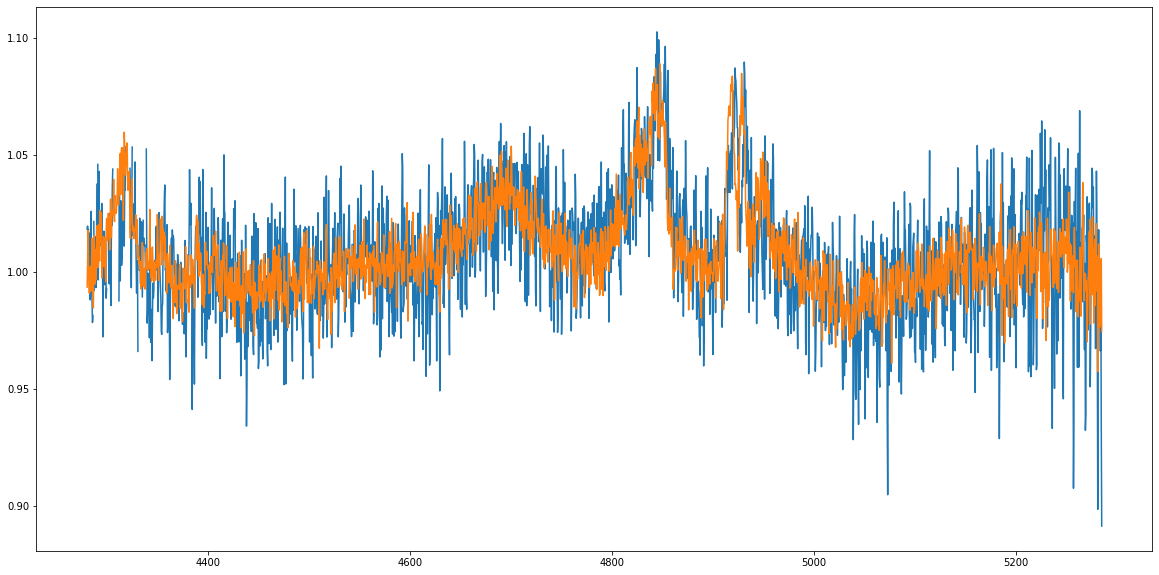

In [11]:
plt.figure(figsize=(20,10))
plt.plot(BJXpoints[1500:3800], testMeanBM)
plt.plot(BJXpoints[1500:3800], testMeanBJ)
#plt.plot(BJXpoints[1500+781:1500+1053], testMeanBM[781:1053])
#plt.plot(BJXpoints[1500+502:1500+731], testMeanBM[502:731])
#plt.plot(BJXpoints[1500+1149:1500+1326], testMeanBM[1149:1326])
#plt.plot(BJXpoints[1500+1446:1500+1542], testMeanBM[1446:1542])


In [18]:
np.mean(timeBM)-np.mean(timeBJ)

289.0530628543347

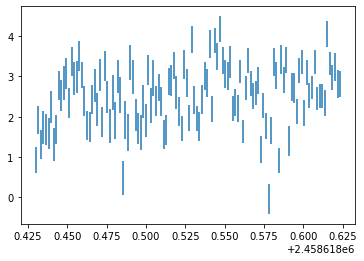

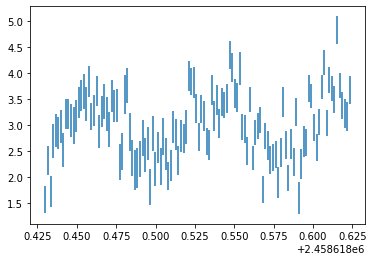

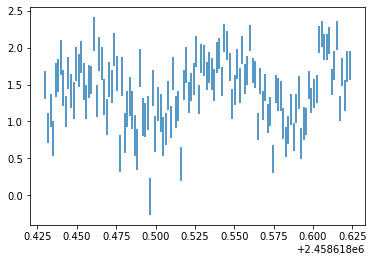

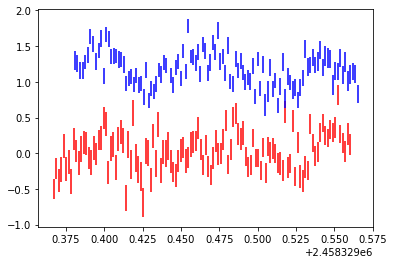

<ErrorbarContainer object of 3 artists>

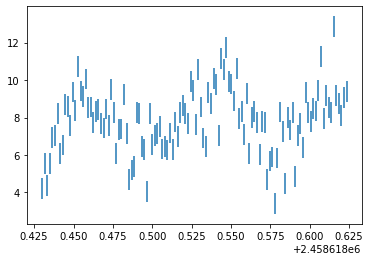

In [13]:
plt.errorbar(timeBM, np.array(BMSM)*dw, yerr=BMSMErrors, ls='')
plt.show()
plt.errorbar(timeBM, np.array(BMPi)*dw, yerr=BMPiErrors, ls='')
plt.show()
plt.errorbar(timeBM, np.array(BMSP)*dw, yerr=BMSPErrors, ls='')

plt.show()
plt.errorbar(np.array(timeBM)-289.0630628543347, (np.array(testMorphM)*dw)-1, yerr=testMorphErrM, ls='',c='r')
plt.errorbar(timeBJ, np.array(testMorph)*dwJ, yerr=testMorpErr, ls='',c='b')
plt.show()
plt.errorbar(timeBM, np.array(BMThree)*dw, yerr=BMThreeErrors, ls='')

#np.save('samePhaseJ.npy', np.array(testMorph)*dwJ)
#np.save('samePhaseM.npy', (np.array(testMorphM)*dw))
#np.save('samePhaseJE.npy', testMorpErr)
#np.save('samePhaseME.npy', testMorphErrM)

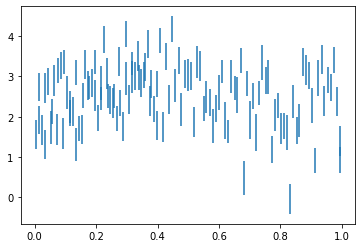

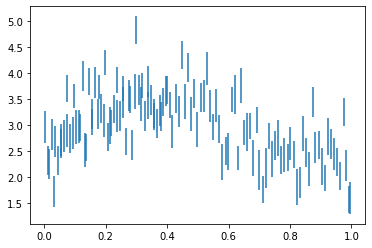

<ErrorbarContainer object of 3 artists>

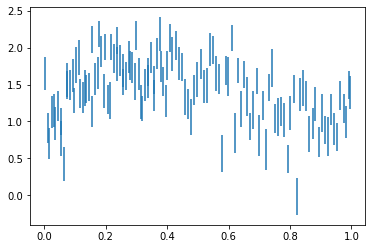

In [9]:
flux1 = np.array(BMSM)*dw
flux2 = np.array(BMPi)*dw
flux3 = np.array(BMSP)*dw
error1 = np.array(BMSMErrors)
error2 = np.array(BMPiErrors)
error3 = np.array(BMSPErrors)
phase1 = foldMeth(timeBM,  0.08029820145279275)
sortIndi = np.argsort(phase1)
phase1 = phase1[sortIndi]
flux1 = flux1[sortIndi]
error1 = error1[sortIndi]
flux2 = flux2[sortIndi]
error2 = error2[sortIndi]
flux3 = flux3[sortIndi]
error3 = error3[sortIndi]
plt.errorbar(phase1,flux1,yerr=error1,ls='')
plt.show()
plt.errorbar(phase1,flux2,yerr=error2,ls='')
plt.show()
plt.errorbar(phase1,flux3,yerr=error3,ls='')

In [9]:
#individual
xpointss = RJXpoints[800:3350]
testMean = np.zeros(len(xpointss))
xp1 = xpointss[:720]
xp2 = xpointss[1050:1225]
xp3 = xpointss[1400:1650]
xp4 = xpointss[1900:1940]
xp5 = xpointss[2400:2550]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
dw = RJXpoints[1501]-RJXpoints[1500]
dwR = dw
RJSM = []
RJSMErrors = []
RJPi = []
SNRsRJ = []
RJPiErrors = []
RJSP = []
RJSPErrors = []
for i in range(113):
    flux = holder_arrayRJ[i]
    if i ==11:
        flux[2725:2745] = np.median(flux[2700:2725])
    if i ==99:
        flux[1580:1600] = np.clip(flux[1580:1600],0,500)
    if i ==111:
        flux[2250:2300] = np.clip(flux[2250:2300], 0,270)
    if i == 43:
        flux[1900:2100] = np.clip(flux[1900:2100], 0,500)
    if i == 109:
        flux[1100:1200] = np.clip(flux[1100:1200],0,500)
    if i ==42:
        flux[2695:2735] = np.clip(flux[2695:2735],0, 400)
    if i == 18:
        flux[2000:3350] = np.clip(flux[2000:3350],0, 500)
    if i ==105:
        flux[2200:2220] = np.clip(flux[2200:2220], 0,350)
    flux = flux[:4100]
    flux = flux[800:3350]
    if i ==44:
        for c, el1 in enumerate(flux[1000:1150]):
            flux[1000+c] = ((1-c/150)*np.median(flux[950:1000])+(c/150)*np.median(flux[1150:1200]))
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fQuart, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = flux/fQuart(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    for count, el in enumerate(fluxNormed):
        if el > 1.15:
            fluxNormed[count] = uniform_filter(fluxNormed,size=200)[count]
        
    fluxNormed = fluxNormed * fQuart(xpointss, popt[0], popt[1], popt[2], popt[3],popt[4])
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fQuart, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = fluxNormed/fQuart(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    testMean = testMean + fluxNormed
    
    RJSM.append(area_est(np.linspace(0,151,152), fluxNormed[762:914], 0, 151)-area_est(np.linspace(0,151,152), np.ones_like(fluxNormed[762:914]), 0, 151))
    thisSNR = SNREst(fluxNormed[1402:1607])
    SNRsRJ.append(np.mean(fluxNormed[1402:1607])/np.std(fluxNormed[1402:1607]))
    thisEWUn = EWUn(152, dw, thisSNR, np.mean(fluxNormed[762:914]), np.median(fluxNormed[1402:1607]),len(fluxNormed[1402:1607]))
    RJSMErrors.append(np.sqrt(thisEWUn))

    RJPi.append(area_est(np.linspace(0,201,202), fluxNormed[1218:1420], 0, 201)-area_est(np.linspace(0,201,202), np.ones_like(fluxNormed[1218:1420]), 0, 201))
    thisEWUn = EWUn(202, dw, thisSNR, np.mean(fluxNormed[1218:1420]), np.median(fluxNormed[1402:1607]),len(fluxNormed[1402:1607]))
    RJPiErrors.append(np.sqrt(thisEWUn))

    RJSP.append(area_est(np.linspace(0,282,283), fluxNormed[1623:1906], 0, 282)-area_est(np.linspace(0,282,283), np.ones_like(fluxNormed[1623:1906]), 0, 282))
    thisEWUn = EWUn(283, dw, thisSNR, np.mean(fluxNormed[1623:1906]), np.median(fluxNormed[1402:1607]),len(fluxNormed[1402:1607]))
    RJSPErrors.append(np.sqrt(thisEWUn))
    
    if i ==0:
        stack = fluxNormed[700:1900]
    else:
        stack = np.vstack((stack, fluxNormed[700:1900]))
testMeanRJ = testMean/113   
stackRJ = stack

In [10]:
xpointss = RJXpoints[800:3350]
testMean = np.zeros(len(xpointss))
xp1 = xpointss[:720]
xp2 = xpointss[1050:1225]
xp3 = xpointss[1400:1650]
xp4 = xpointss[1900:1940]
xp5 = xpointss[2400:2550]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
dw = RJXpoints[1501]-RJXpoints[1500]
dwR = dw
RJThree = []
RJThreeErrors = []
for i in range(113):
    flux = holder_arrayRJ[i]
    if i ==11:
        flux[2725:2745] = np.median(flux[2700:2725])
    if i ==99:
        flux[1580:1600] = np.clip(flux[1580:1600],0,500)
    if i ==111:
        flux[2250:2300] = np.clip(flux[2250:2300], 0,270)
    if i == 43:
        flux[1900:2100] = np.clip(flux[1900:2100], 0,500)
    if i == 109:
        flux[1100:1200] = np.clip(flux[1100:1200],0,500)
    if i ==42:
        flux[2695:2735] = np.clip(flux[2695:2735],0, 400)
    if i == 18:
        flux[2000:3350] = np.clip(flux[2000:3350],0, 500)
    if i ==105:
        flux[2200:2220] = np.clip(flux[2200:2220], 0,350)
    flux = flux[:4100]
    flux = flux[800:3350]
    if i ==44:
        for c, el1 in enumerate(flux[1000:1150]):
            flux[1000+c] = ((1-c/150)*np.median(flux[950:1000])+(c/150)*np.median(flux[1150:1200]))
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fQuart, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = flux/fQuart(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    for count, el in enumerate(fluxNormed):
        if el > 1.15:
            fluxNormed[count] = uniform_filter(fluxNormed,size=200)[count]
        
    fluxNormed = fluxNormed * fQuart(xpointss, popt[0], popt[1], popt[2], popt[3],popt[4])
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fQuart, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = fluxNormed/fQuart(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    testMean = testMean + fluxNormed
    
    RJThree.append(area_est(np.linspace(0,1143,1144), fluxNormed[762:1906], 0, 1143)-area_est(np.linspace(0,1143,1144), np.ones_like(fluxNormed[762:1906]), 0, 1143))
    thisSNR = SNREst(fluxNormed[1402:1607])
    SNRsRJ.append(np.mean(fluxNormed[1402:1607])/np.std(fluxNormed[1402:1607]))
    thisEWUn = EWUn(1144, dw, thisSNR, np.mean(fluxNormed[762:1906]), np.median(fluxNormed[1402:1607]),len(fluxNormed[1402:1607]))
    RJThreeErrors.append(np.sqrt(thisEWUn))
    
    if i ==0:
        stack = fluxNormed[700:1900]
    else:
        stack = np.vstack((stack, fluxNormed[700:1900]))
testMeanRJ = testMean/113   
stackRJ = stack

In [14]:
np.mean(SNRsRJ)

23.26960066465686

In [45]:
dwR

0.48821147892431327

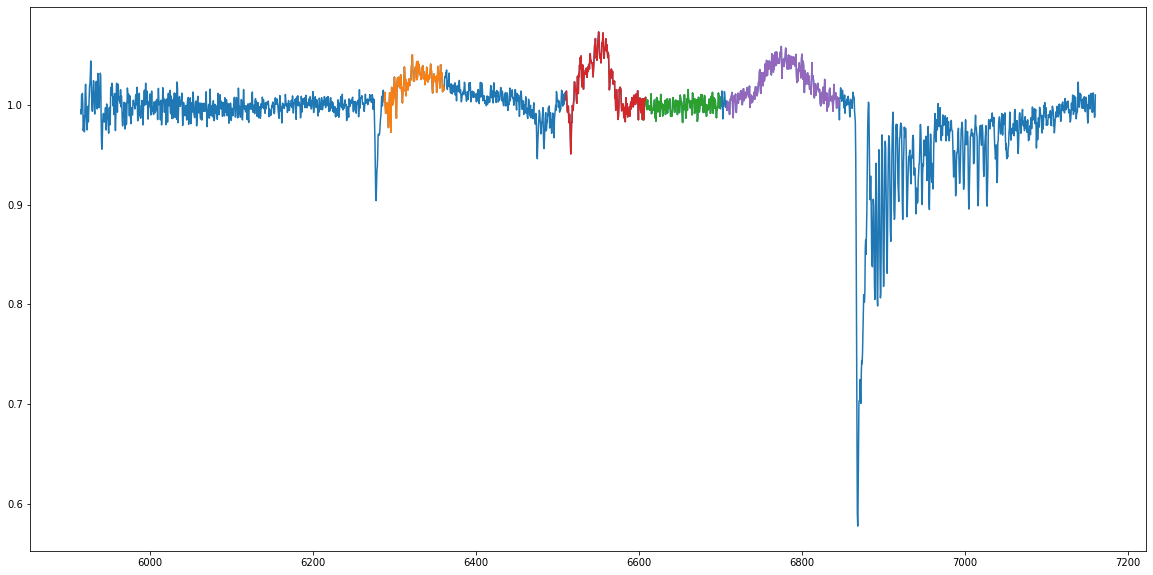

In [11]:
plt.figure(figsize=(20,10))
plt.plot(RJXpoints[800:3350], testMeanRJ)
plt.plot(RJXpoints[800+762:800+914], testMeanRJ[762:914])
plt.plot(RJXpoints[800+1402:800+1607], testMeanRJ[1402:1607])
plt.plot(RJXpoints[800+1218:800+1420], testMeanRJ[1218:1420])
plt.plot(RJXpoints[800+1623:800+1906], testMeanRJ[1623:1906])


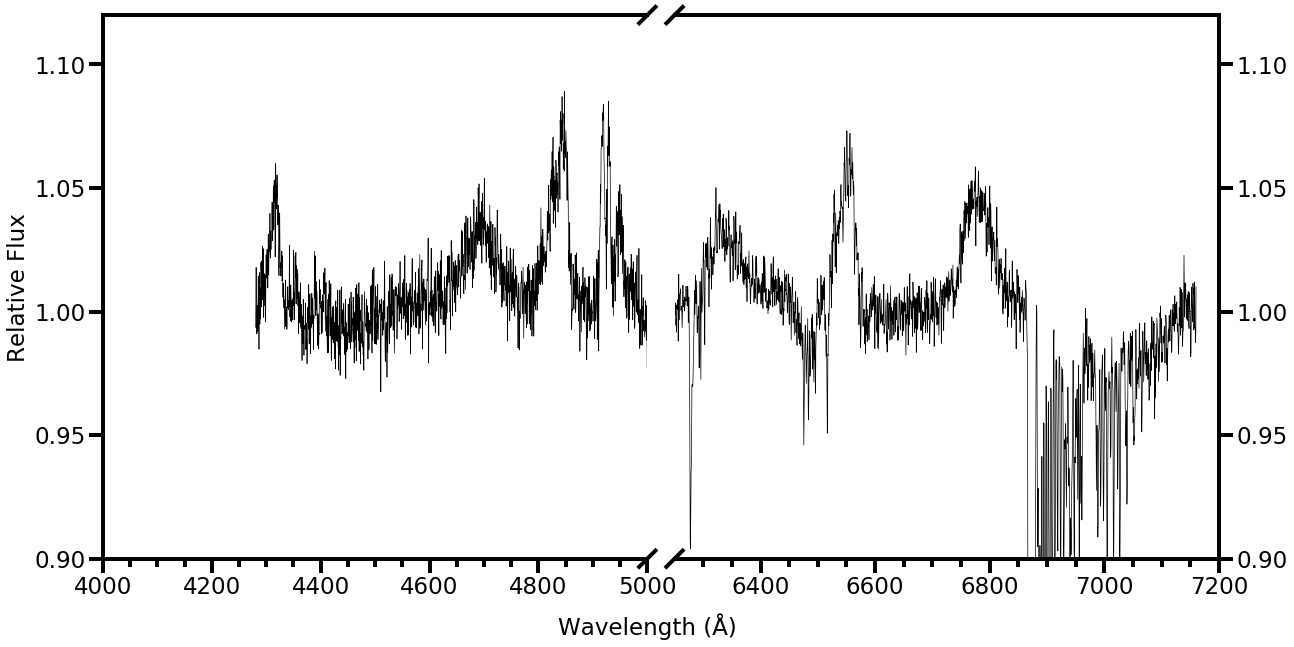

In [13]:

from pylab import *
rc('axes', linewidth=4)
f,(ax,ax2) = plt.subplots(1,2,gridspec_kw={'hspace': 0.15, 'wspace': 0.05},sharey=True, facecolor='w', figsize=(20,10))

# plot the same data on both axes
ax.plot(BJXpoints[1500:3800], testMeanBJ, 'k-', lw=0.7)
ax2.plot(RJXpoints[800:3350], testMeanRJ, 'k-', lw=0.7)
ax.set_xlabel(r"Wavelength (Å)", fontsize=23)
ax.set_ylabel('Relative Flux', fontsize=23)
ax.xaxis.set_label_coords(1.0, -0.1)
ax.set_xlim(4000,5000)
ax2.set_xlim(6250,7200)

ax.set_ylim(0.9,1.12)
ax2.set_ylim(0.9,1.12)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax.tick_params(labelright='off')
ax2.tick_params(labelright='on')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs, lw=4)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs, lw=4)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs, lw=4)
ax2.plot((-d,+d), (-d,+d), **kwargs, lw=4)
ax.set_yticks(np.arange(0.9, 1.12, 0.05))
ax2.set_yticks(np.arange(0.9, 1.12, 0.05))
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
#ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', width=4)
ax.tick_params(which='major', length=14)
ax.tick_params(which='minor', length=8)
ax2.tick_params(which='both', width=4)
ax2.tick_params(which='major', length=14)
ax2.tick_params(which='minor', length=8)
ax.tick_params(labelsize=23)
ax2.tick_params(labelsize=23)


plt.show()

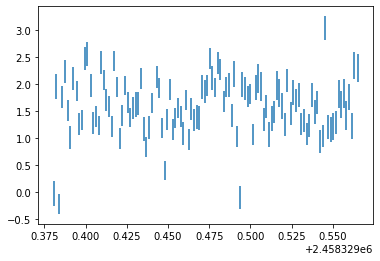

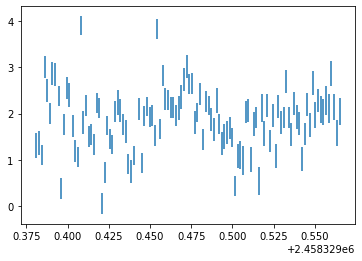

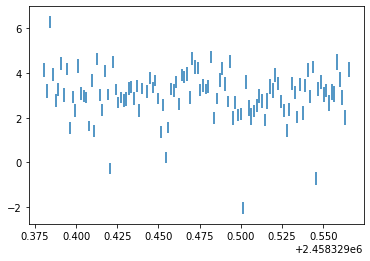

<ErrorbarContainer object of 3 artists>

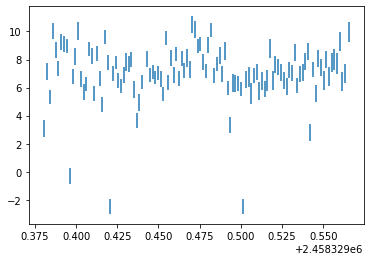

In [17]:
plt.errorbar(timeRJ, np.array(RJSM)*dw, yerr=RJSMErrors, ls='')
plt.show()
plt.errorbar(timeRJ, np.array(RJPi)*dw, yerr=RJPiErrors, ls='')
plt.show()
plt.errorbar(timeRJ, np.array(RJSP)*dw, yerr=RJSPErrors, ls='')
plt.show()
plt.errorbar(timeRJ, np.array(RJThree)*dw, yerr=RJThreeErrors, ls='')

In [52]:
#individual
xpointss = RJXpoints[800:3350]
testMean = np.zeros(len(xpointss))
xp1 = xpointss[:720]
xp2 = xpointss[1050:1225]
xp3 = xpointss[1400:1650]
xp4 = xpointss[1900:1940]
xp5 = xpointss[2400:2550]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
dw = RJXpoints[1501]-RJXpoints[1500]
RMSM = []
RMSMErrors = []
RMPi = []
SNRsRM = []
RMPiErrors = []
RMSP = []
RMSPErrors = []
for i in range(120):
    flux = holder_arrayRM[i]
    if i ==12:
        flux[2395:2410] = np.clip(flux[2395:2410], 0,350)
    if i ==40:
        flux[990:1010]= np.clip(flux[990:1010], 0, 460)
        flux[3645:3670] = np.clip(flux[3645:3670], 0,200)
    if i ==45:
        flux[2310:2335]= np.clip(flux[2310:2335],0,300)
    if i ==65:
        flux[1420:1455] = np.clip(flux[1420:1455], 0,500)
    if i ==69:
        flux[1950:1970] = np.clip(flux[1950:1970],0,400)
    if i == 83:
        flux[1855:1870] = np.clip(flux[1855:1870],0,400)
        flux[2120:2130] = np.clip(flux[2120:2130],0,400)
    flux = flux[800:3350]
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fQuart, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = flux/fQuart(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    for count, el in enumerate(fluxNormed):
        if el > 1.15:
            fluxNormed[count] = uniform_filter(fluxNormed,size=200)[count]
        
    fluxNormed = fluxNormed * fQuart(xpointss, popt[0], popt[1], popt[2], popt[3],popt[4])
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fQuart, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = fluxNormed/fQuart(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    testMean = testMean + fluxNormed
    
    RMSM.append(area_est(np.linspace(0,151,152), fluxNormed[762:914], 0, 151)-area_est(np.linspace(0,151,152), np.ones_like(fluxNormed[762:914]), 0, 151))
    thisSNR = SNREst(fluxNormed[1402:1607])
    SNRsRM.append(np.mean(fluxNormed[1402:1607])/np.std(fluxNormed[1402:1607]))
    thisEWUn = EWUn(152, dw, thisSNR, np.mean(fluxNormed[762:914]), np.median(fluxNormed[1402:1607]),len(fluxNormed[1402:1607]))
    RMSMErrors.append(np.sqrt(thisEWUn))

    RMPi.append(area_est(np.linspace(0,201,202), fluxNormed[1218:1420], 0, 201)-area_est(np.linspace(0,201,202), np.ones_like(fluxNormed[1218:1420]), 0, 201))
    thisEWUn = EWUn(202, dw, thisSNR, np.mean(fluxNormed[1218:1420]), np.median(fluxNormed[1402:1607]),len(fluxNormed[1402:1607]))
    RMPiErrors.append(np.sqrt(thisEWUn))

    RMSP.append(area_est(np.linspace(0,282,283), fluxNormed[1623:1906], 0, 282)-area_est(np.linspace(0,282,283), np.ones_like(fluxNormed[1623:1906]), 0, 282))
    thisEWUn = EWUn(283, dw, thisSNR, np.mean(fluxNormed[1623:1906]), np.median(fluxNormed[1402:1607]),len(fluxNormed[1402:1607]))
    RMSPErrors.append(np.sqrt(thisEWUn))
    
    if i ==0:
        stack = fluxNormed[700:1900]
    else:
        stack = np.vstack((stack, fluxNormed[700:1900]))
testMeanRM = testMean/120  
stackRM = stack

In [20]:
xpointss = RJXpoints[800:3350]
testMean = np.zeros(len(xpointss))
xp1 = xpointss[:720]
xp2 = xpointss[1050:1225]
xp3 = xpointss[1400:1650]
xp4 = xpointss[1900:1940]
xp5 = xpointss[2400:2550]
xpF = np.append(xp1,xp2)
xpF = np.append(xpF, xp3)
xpF = np.append(xpF, xp4)
xpF = np.append(xpF, xp5)
dw = RJXpoints[1501]-RJXpoints[1500]
RMThree = []
RMThreeErrors = []
for i in range(120):
    flux = holder_arrayRM[i]
    if i ==12:
        flux[2395:2410] = np.clip(flux[2395:2410], 0,350)
    if i ==40:
        flux[990:1010]= np.clip(flux[990:1010], 0, 460)
        flux[3645:3670] = np.clip(flux[3645:3670], 0,200)
    if i ==45:
        flux[2310:2335]= np.clip(flux[2310:2335],0,300)
    if i ==65:
        flux[1420:1455] = np.clip(flux[1420:1455], 0,500)
    if i ==69:
        flux[1950:1970] = np.clip(flux[1950:1970],0,400)
    if i == 83:
        flux[1855:1870] = np.clip(flux[1855:1870],0,400)
        flux[2120:2130] = np.clip(flux[2120:2130],0,400)
    flux = flux[800:3350]
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fQuart, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = flux/fQuart(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    for count, el in enumerate(fluxNormed):
        if el > 1.15:
            fluxNormed[count] = uniform_filter(fluxNormed,size=200)[count]
        
    fluxNormed = fluxNormed * fQuart(xpointss, popt[0], popt[1], popt[2], popt[3],popt[4])
    tmp1 = flux[:720]
    tmp2 = flux[1050:1225]
    tmp3 = flux[1400:1650]
    tmp4 = flux[1900:1940]
    tmp5 = flux[2400:2550]
    emptiedflux = np.append(tmp1,tmp2)
    emptiedflux = np.append(emptiedflux, tmp3)
    emptiedflux = np.append(emptiedflux, tmp4)
    emptiedflux = np.append(emptiedflux, tmp5)
    popt, pcov = curve_fit(fQuart, xpF, uniform_filter(emptiedflux,size=20))
    fluxNormed = fluxNormed/fQuart(xpointss, popt[0], popt[1], popt[2], popt[3], popt[4])
    testMean = testMean + fluxNormed
    
    RMThree.append(area_est(np.linspace(0,1143,1144), fluxNormed[762:1906], 0, 1143)-area_est(np.linspace(0,1143,1144), np.ones_like(fluxNormed[762:1906]), 0, 1143))
    thisSNR = SNREst(fluxNormed[1402:1607])
    SNRsRJ.append(np.mean(fluxNormed[1402:1607])/np.std(fluxNormed[1402:1607]))
    thisEWUn = EWUn(1144, dw, thisSNR, np.mean(fluxNormed[762:1906]), np.median(fluxNormed[1402:1607]),len(fluxNormed[1402:1607]))
    RMThreeErrors.append(np.sqrt(thisEWUn))
    
    if i ==0:
        stack = fluxNormed[700:1900]
    else:
        stack = np.vstack((stack, fluxNormed[700:1900]))
testMeanRM = testMean/120  
stackRM = stack


    

In [16]:
np.std(SNRsRM)

1.850403502781314

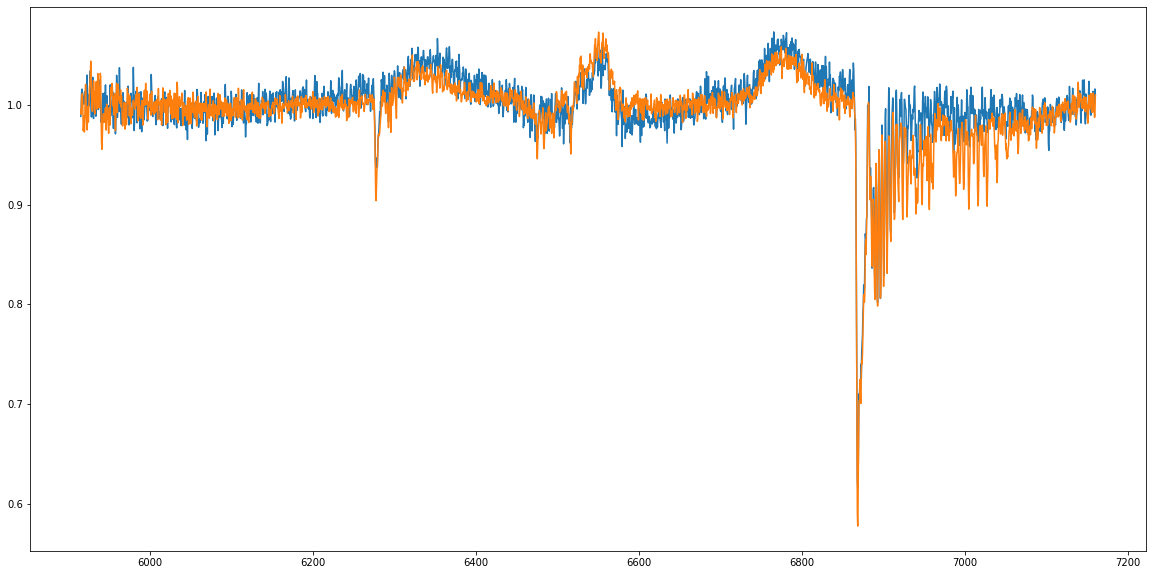

In [37]:
plt.figure(figsize=(20,10))
plt.plot(RJXpoints[800:3350], testMeanRM)
plt.plot(RJXpoints[800:3350], testMeanRJ)
#plt.plot(RJXpoints[800+762:800+914], testMeanRM[762:914])
#plt.plot(RJXpoints[800+1402:800+1607], testMeanRM[1402:1607])
#plt.plot(RJXpoints[800+1218:800+1420], testMeanRM[1218:1420])
#plt.plot(RJXpoints[800+1623:800+1906], testMeanRM[1623:1906])


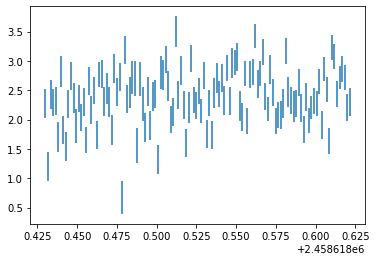

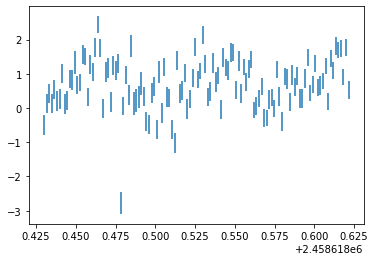

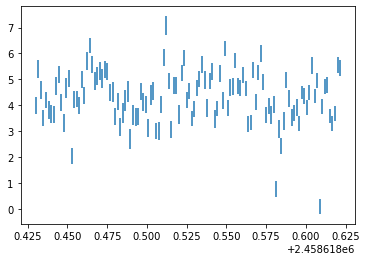

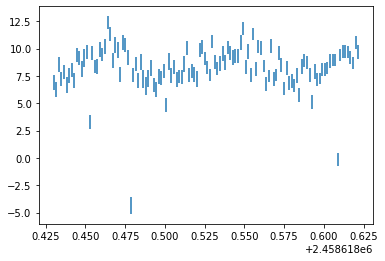

In [21]:
plt.errorbar(timeRM, np.array(RMSM)*dw, yerr=RMSMErrors, ls='')
plt.show()
plt.errorbar(timeRM, np.array(RMPi)*dw, yerr=RMPiErrors, ls='')
plt.show()
plt.errorbar(timeRM, np.array(RMSP)*dw, yerr=RMSPErrors, ls='')
plt.show()
plt.errorbar(timeRM, np.array(RMThree)*dw, yerr=RMThreeErrors, ls='')
plt.show()

In [90]:
1/0.08029867

12.453506390579072

In [53]:
BJSMw = np.array(BJSM)*dwB
BJPiw = np.array(BJPi)*dwB
BJSPw = np.array(BJSP)*dwB
BMSMw = np.array(BMSM)*dwB
BMPiw = np.array(BMPi)*dwB
BMSPw = np.array(BMSP)*dwB
RJSMw = np.array(RJSM)*dwR
RJPiw = np.array(RJPi)*dwR
RJSPw = np.array(RJSP)*dwR
RMSMw = np.array(RMSM)*dwR
RMPiw = np.array(RMPi)*dwR
RMSPw = np.array(RMSP)*dwR

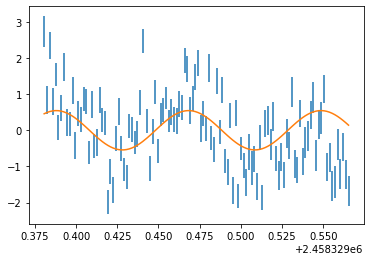

BJSMS:  0.28863888575006236


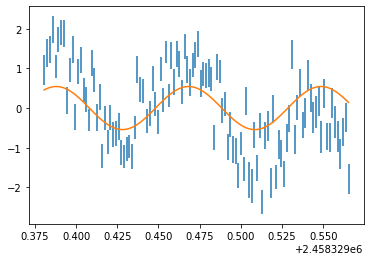

BJPiS  0.42877221392120357


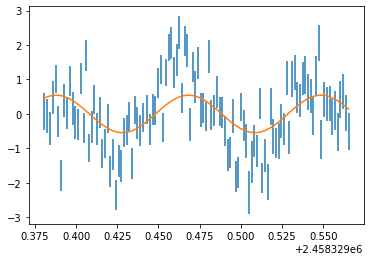

BJSPS  0.4226418296197946


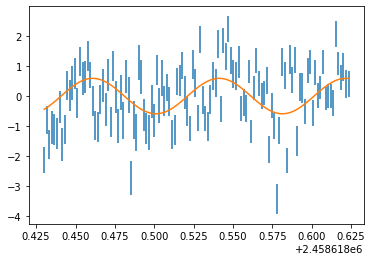

BMSMS  0.23819362063362737


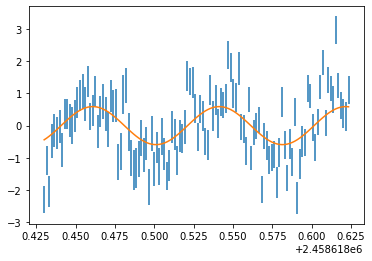

BMPiS  0.4737223711807701


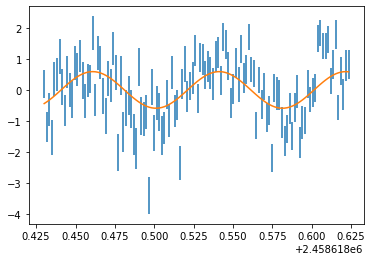

BMSPS  0.4216698583050339


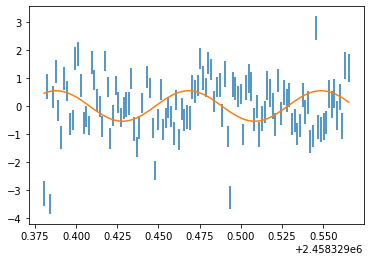

RJSMS  -0.013842177620140284


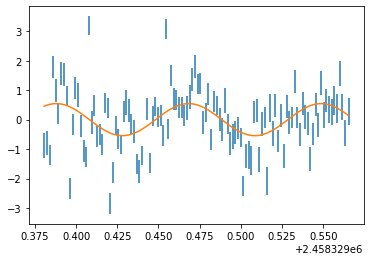

RJPiS  0.29751454104834163


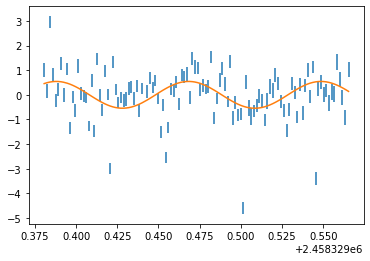

RJSPS  0.16258281585385337


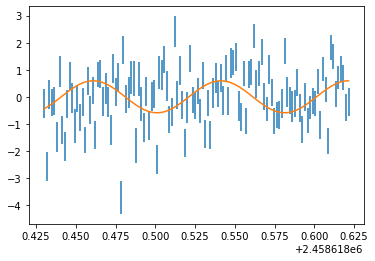

RMSMS  0.0431431701474998


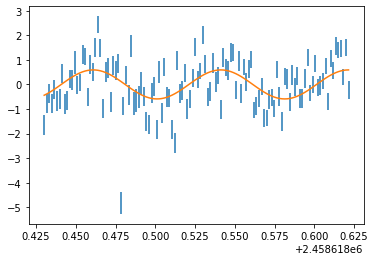

RMPiS  0.3213252877682181


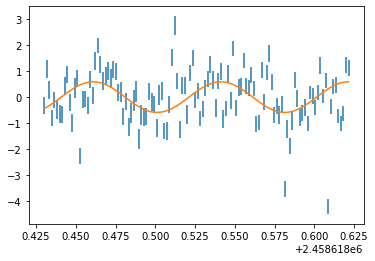

RMSPS  0.18597369486320403


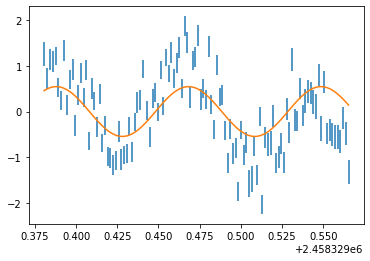

all BJews  0.6496760163571315


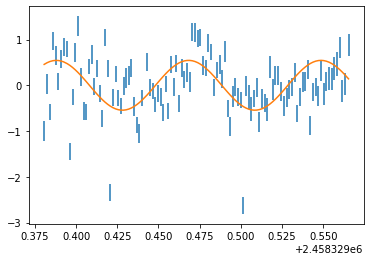

all RJEWs  0.6804810249770553


In [89]:
BJSMS = (BJSMw - np.mean(BJSMw))/np.std(BJSMw)
BJSMSe = BJSMErrors/np.std(BJSMw)
plt.errorbar(timeBJ, BJSMS, yerr=BJSMSe,ls='')
plt.plot(timeBJ, 0.54405838*np.sin(np.array(timeBJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi))
plt.show()
timeBJ = np.array(timeBJ)
model = 0.54405838*np.sin(np.array(timeBJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi)
print('BJSMS: ',1-mean_squared_error(BJSMS, model)/1.1558837105474753)


BJPiS = (BJPiw - np.mean(BJPiw))/np.std(BJPiw)
BJPiSe = BJPiErrors/np.std(BJPiw)
plt.errorbar(timeBJ, BJPiS, yerr=BJPiSe,ls='')
plt.plot(timeBJ, 0.54405838*np.sin(np.array(timeBJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi))
plt.show()
timeBJ = np.array(timeBJ)
model = 0.54405838*np.sin(np.array(timeBJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi)
print('BJPiS ', 1-mean_squared_error(BJPiS, model)/1.1558837105474753)
#errors = []
#1.226229526045207
#for i in range(100000):
#    errors.append(mean_squared_error(np.random.normal(0, 1, len(timeBJ)),model))
#print(np.mean(errors))
#average error is 1.1558837105474753
#the clsoer to one, the better the fit


BJSPS = (BJSPw - np.mean(BJSPw))/np.std(BJSPw)
BJSPSe = BJSPErrors/np.std(BJSPw)
plt.errorbar(timeBJ, BJSPS, yerr=BJSPSe,ls='')
plt.plot(timeBJ, 0.54405838*np.sin(np.array(timeBJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi))
plt.show()
timeBJ = np.array(timeBJ)
model = 0.54405838*np.sin(np.array(timeBJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi)
print('BJSPS ',1-mean_squared_error(BJSPS, model)/1.1558837105474753)


BMSMS = (BMSMw - np.mean(BMSMw))/np.std(BMSMw)
BMSMSe = BMSMErrors/np.std(BMSMw)
timeBM = np.array(timeBM)
plt.errorbar(timeBM, BMSMS, yerr=BMSMSe,ls='')
plt.plot(timeBM, 0.590471912*np.sin(np.array(timeBM)*(2*np.pi/0.08029867)+0.534776*2*np.pi))
plt.show()
model = 0.590471912*np.sin(np.array(timeBM)*(2*np.pi/0.08029867)+0.534776*2*np.pi)
print('BMSMS ',1-mean_squared_error(BMSMS, model)/1.1558837105474753)


BMPiS = (BMPiw - np.mean(BMPiw))/np.std(BMPiw)
BMPiSe = BMPiErrors/np.std(BMPiw)
plt.errorbar(timeBM, BMPiS, yerr=BMPiSe,ls='')
plt.plot(timeBM, 0.590471912*np.sin(np.array(timeBM)*(2*np.pi/0.08029867)+0.534776*2*np.pi))
plt.show()
model = 0.590471912*np.sin(np.array(timeBM)*(2*np.pi/0.08029867)+0.534776*2*np.pi)
print('BMPiS ',1-mean_squared_error(BMPiS, model)/1.1558837105474753)

BMSPS = (BMSPw - np.mean(BMSPw))/np.std(BMSPw)
BMSPSe = BMSPErrors/np.std(BMSPw)
plt.errorbar(timeBM, BMSPS, yerr=BMSPSe,ls='')
plt.plot(timeBM, 0.590471912*np.sin(np.array(timeBM)*(2*np.pi/0.08029867)+0.534776*2*np.pi))
plt.show()
model = 0.590471912*np.sin(np.array(timeBM)*(2*np.pi/0.08029867)+0.534776*2*np.pi)
print('BMSPS ',1-mean_squared_error(BMSPS, model)/1.1558837105474753)


RJSMS = (RJSMw - np.mean(RJSMw))/np.std(RJSMw)
RJSMSe = RJSMErrors/np.std(RJSMw)
timeRJ = np.array(timeRJ)
plt.errorbar(timeRJ, RJSMS, yerr=RJSMSe,ls='')
plt.plot(timeRJ, 0.54405838*np.sin(np.array(timeRJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi))
plt.show()
model = 0.54405838*np.sin(np.array(timeRJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi)
print('RJSMS ',1-mean_squared_error(RJSMS, model)/1.1558837105474753)


RJPiS = (RJPiw - np.mean(RJPiw))/np.std(RJPiw)
RJPiSe = RJPiErrors/np.std(RJPiw)
timeRJ = np.array(timeRJ)
plt.errorbar(timeRJ, RJPiS, yerr=RJPiSe,ls='')
plt.plot(timeRJ, 0.54405838*np.sin(np.array(timeRJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi))
plt.show()
model = 0.54405838*np.sin(np.array(timeRJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi)
print('RJPiS ',1-mean_squared_error(RJPiS, model)/1.1558837105474753)

RJSPS = (RJSPw - np.mean(RJSPw))/np.std(RJSPw)
RJSPSe = RJSPErrors/np.std(RJSPw)
plt.errorbar(timeRJ, RJSPS, yerr=RJSPSe,ls='')
plt.plot(timeRJ, 0.54405838*np.sin(np.array(timeRJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi))
plt.show()
model = 0.54405838*np.sin(np.array(timeRJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi)
print('RJSPS ',1-mean_squared_error(RJSPS, model)/1.1558837105474753)


RMSMS = (RMSMw - np.mean(RMSMw))/np.std(RMSMw)
RMSMSe = RMSMErrors/np.std(RMSMw)
timeRM = np.array(timeRM)
plt.errorbar(timeRM, RMSMS, yerr=RMSMSe,ls='')
plt.plot(timeRM, 0.590471912*np.sin(np.array(timeRM)*(2*np.pi/0.08029867)+0.534776*2*np.pi))
plt.show()
model = 0.590471912*np.sin(np.array(timeRM)*(2*np.pi/0.08029867)+0.534776*2*np.pi)
print('RMSMS ',1-mean_squared_error(RMSMS, model)/1.1558837105474753)


RMPiS = (RMPiw - np.mean(RMPiw))/np.std(RMPiw)
RMPiSe = RMPiErrors/np.std(RMPiw)
plt.errorbar(timeRM, RMPiS, yerr=RMPiSe,ls='')
plt.plot(timeRM, 0.590471912*np.sin(np.array(timeRM)*(2*np.pi/0.08029867)+0.534776*2*np.pi))
plt.show()
model = 0.590471912*np.sin(np.array(timeRM)*(2*np.pi/0.08029867)+0.534776*2*np.pi)
print('RMPiS ',1-mean_squared_error(RMPiS, model)/1.1558837105474753)

RMSPS = (RMSPw - np.mean(RMSPw))/np.std(RMSPw)
RMSPSe = RMSPErrors/np.std(RMSPw)
plt.errorbar(timeRM, RMSPS, yerr=RMSPSe,ls='')
plt.plot(timeRM, 0.590471912*np.sin(np.array(timeRM)*(2*np.pi/0.08029867)+0.534776*2*np.pi))
plt.show()
model = 0.590471912*np.sin(np.array(timeRM)*(2*np.pi/0.08029867)+0.534776*2*np.pi)
print('RMSPS ',1-mean_squared_error(RMSPS, model)/1.1558837105474753)



plt.errorbar(timeBJ, BJEWs, yerr=BJEWsErr, ls='')
plt.plot(timeBJ, 0.54405838*np.sin(np.array(timeBJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi))
plt.show()
model = 0.54405838*np.sin(np.array(timeBJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi)
print('all BJews ',1-mean_squared_error(BJEWs, model)/1.1558837105474753)


plt.errorbar(timeRJ, RJEWs, yerr=RJEWsErr, ls='')
plt.plot(timeRJ, 0.54405838*np.sin(np.array(timeRJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi))
plt.show()
model = 0.54405838*np.sin(np.array(timeRJ)*(2*np.pi/0.08029867)+0.506143*2*np.pi)
print('all RJEWs ',1-mean_squared_error(RJEWs, model)/1.1558837105474753)

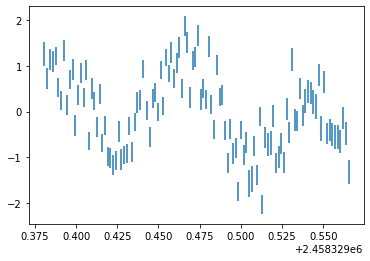

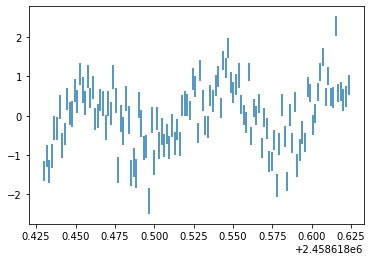

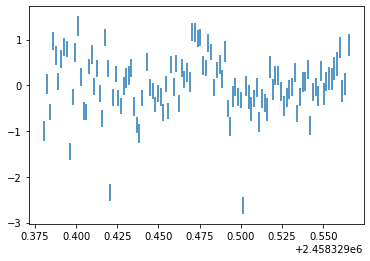

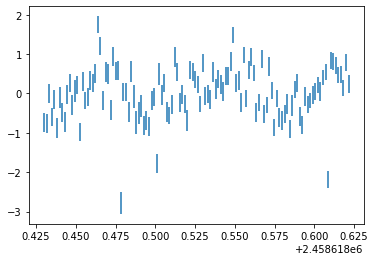

In [28]:
BJSMS = (BJSMw - np.mean(BJSMw))/np.std(BJSMw)
BJSMSe = BJSMErrors/np.std(BJSMw)
BJPiS = (BJPiw - np.mean(BJPiw))/np.std(BJPiw)
BJPiSe = BJPiErrors/np.std(BJPiw)

BJSPS = (BJSPw - np.mean(BJSPw))/np.std(BJSPw)
BJSPSe = BJSPErrors/np.std(BJSPw)

BJEWs = np.vstack((BJSMS, BJPiS))
BJEWs = np.vstack((BJEWs, BJSPS))
BJEWs = np.average(BJEWs, axis=0)

BJEWsErr = np.vstack((BJSMSe, BJPiSe))
BJEWsErr = np.vstack((BJEWsErr, BJSPSe))
BJEWsErr = np.average(BJEWsErr, axis=0)/np.sqrt(3)
plt.errorbar(timeBJ, BJEWs, yerr=BJEWsErr, ls='')
plt.show()
#np.save('BJEWs.npy', BJEWs)
#np.save('BJEWsErr.npy', BJEWsErr)


BMSMS = (BMSMw - np.mean(BMSMw))/np.std(BMSMw)
BMSMSe = BMSMErrors/np.std(BMSMw)

BMPiS = (BMPiw - np.mean(BMPiw))/np.std(BMPiw)
BMPiSe = BMPiErrors/np.std(BMPiw)

BMSPS = (BMSPw - np.mean(BMSPw))/np.std(BMSPw)
BMSPSe = BMSPErrors/np.std(BMSPw)

BMEWs = np.vstack((BMSMS, BMPiS))
BMEWs = np.vstack((BMEWs, BMSPS))
BMEWs = np.average(BMEWs, axis=0)

BMEWsErr = np.vstack((BMSMSe, BMPiSe))
BMEWsErr = np.vstack((BMEWsErr, BMSPSe))
BMEWsErr = np.average(BMEWsErr, axis=0)/np.sqrt(3)
plt.errorbar(timeBM, BMEWs, yerr=BMEWsErr, ls='')
plt.show()
#np.save('BMEWs.npy', BMEWs)
#np.save('BMEWsErr.npy', BMEWsErr)


RJSMS = (RJSMw - np.mean(RJSMw))/np.std(RJSMw)
RJSMSe = RJSMErrors/np.std(RJSMw)

RJPiS = (RJPiw - np.mean(RJPiw))/np.std(RJPiw)
RJPiSe = RJPiErrors/np.std(RJPiw)

RJSPS = (RJSPw - np.mean(RJSPw))/np.std(RJSPw)
RJSPSe = RJSPErrors/np.std(RJSPw)

RJEWs = np.vstack((RJSMS, RJPiS))
RJEWs = np.vstack((RJEWs, RJSPS))
RJEWs = np.average(RJEWs, axis=0)

RJEWsErr = np.vstack((RJSMSe, RJPiSe))
RJEWsErr = np.vstack((RJEWsErr, RJSPSe))
RJEWsErr = np.average(RJEWsErr, axis=0)/np.sqrt(3)
plt.errorbar(timeRJ, RJEWs, yerr=RJEWsErr, ls='')
plt.show()
#np.save('RJEWs.npy', RJEWs)
#np.save('RJEWsErr.npy', RJEWsErr)


RMSMS = (RMSMw - np.mean(RMSMw))/np.std(RMSMw)
RMSMSe = RMSMErrors/np.std(RMSMw)

RMPiS = (RMPiw - np.mean(RMPiw))/np.std(RMPiw)
RMPiSe = RMPiErrors/np.std(RMPiw)

RMSPS = (RMSPw - np.mean(RMSPw))/np.std(RMSPw)
RMSPSe = RMSPErrors/np.std(RMSPw)

RMEWs = np.vstack((RMSMS, RMPiS))
RMEWs = np.vstack((RMEWs, RMSPS))
RMEWs = np.average(RMEWs, axis=0)

RMEWsErr = np.vstack((RMSMSe, RMPiSe))
RMEWsErr = np.vstack((RMEWsErr, RMSPSe))
RMEWsErr = np.average(RMEWsErr, axis=0)/np.sqrt(3)
plt.errorbar(timeRM, RMEWs, yerr=RMEWsErr, ls='')
plt.show()
#np.save('RMEWs.npy', RMEWs)
#np.save('RMEWsErr.npy', RMEWsErr)
#plt.errorbar(timeBJ, np.array(BJPi)*dw, yerr=BJPiErrors, ls='')
#plt.show()
#plt.errorbar(timeBJ, np.array(BJSP)*dw, yerr=BJSPErrors, ls='')

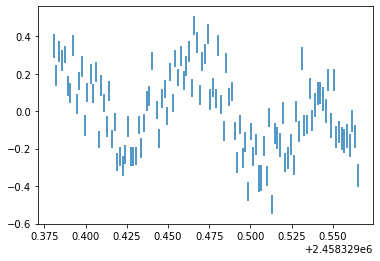

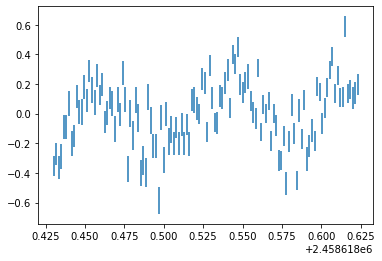

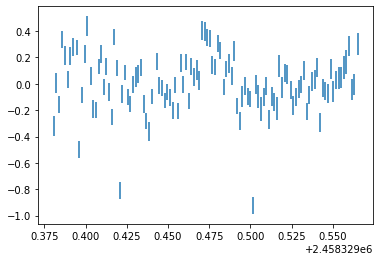

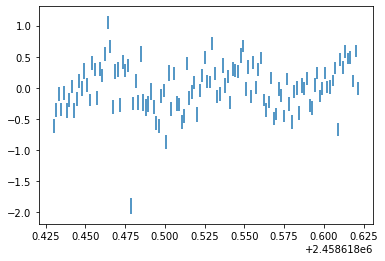

In [54]:
BJSMS = (BJSMw - np.mean(BJSMw))/np.mean(BJSMw)
BJSMSe = BJSMErrors/np.mean(BJSMw)
BJPiS = (BJPiw - np.mean(BJPiw))/np.mean(BJPiw)
BJPiSe = BJPiErrors/np.mean(BJPiw)

BJSPS = (BJSPw - np.mean(BJSPw))/np.mean(BJSPw)
BJSPSe = BJSPErrors/np.mean(BJSPw)

BJEWs = np.vstack((BJSMS, BJPiS))
BJEWs = np.vstack((BJEWs, BJSPS))
BJEWs = np.average(BJEWs, axis=0)

BJEWsErr = np.vstack((BJSMSe, BJPiSe))
BJEWsErr = np.vstack((BJEWsErr, BJSPSe))
BJEWsErr = np.average(BJEWsErr, axis=0)/np.sqrt(3)
plt.errorbar(timeBJ, BJEWs, yerr=BJEWsErr, ls='')
plt.show()
np.save('BJEWs.npy', BJEWs)
np.save('BJEWsErr.npy', BJEWsErr)


BMSMS = (BMSMw - np.mean(BMSMw))/np.mean(BMSMw)
BMSMSe = BMSMErrors/np.mean(BMSMw)

BMPiS = (BMPiw - np.mean(BMPiw))/np.mean(BMPiw)
BMPiSe = BMPiErrors/np.mean(BMPiw)

BMSPS = (BMSPw - np.mean(BMSPw))/np.mean(BMSPw)
BMSPSe = BMSPErrors/np.mean(BMSPw)

BMEWs = np.vstack((BMSMS, BMPiS))
BMEWs = np.vstack((BMEWs, BMSPS))
BMEWs = np.average(BMEWs, axis=0)

BMEWsErr = np.vstack((BMSMSe, BMPiSe))
BMEWsErr = np.vstack((BMEWsErr, BMSPSe))
BMEWsErr = np.average(BMEWsErr, axis=0)/np.sqrt(3)
plt.errorbar(timeBM, BMEWs, yerr=BMEWsErr, ls='')
plt.show()
np.save('BMEWs.npy', BMEWs)
np.save('BMEWsErr.npy', BMEWsErr)


RJSMS = (RJSMw - np.mean(RJSMw))/np.mean(RJSMw)
RJSMSe = RJSMErrors/np.mean(RJSMw)

RJPiS = (RJPiw - np.mean(RJPiw))/np.mean(RJPiw)
RJPiSe = RJPiErrors/np.mean(RJPiw)

RJSPS = (RJSPw - np.mean(RJSPw))/np.mean(RJSPw)
RJSPSe = RJSPErrors/np.mean(RJSPw)

RJEWs = np.vstack((RJSMS, RJPiS))
RJEWs = np.vstack((RJEWs, RJSPS))
RJEWs = np.average(RJEWs, axis=0)

RJEWsErr = np.vstack((RJSMSe, RJPiSe))
RJEWsErr = np.vstack((RJEWsErr, RJSPSe))
RJEWsErr = np.average(RJEWsErr, axis=0)/np.sqrt(3)
plt.errorbar(timeRJ, RJEWs, yerr=RJEWsErr, ls='')
plt.show()
np.save('RJEWs.npy', RJEWs)
np.save('RJEWsErr.npy', RJEWsErr)


RMSMS = (RMSMw - np.mean(RMSMw))/np.mean(RMSMw)
RMSMSe = RMSMErrors/np.mean(RMSMw)

RMPiS = (RMPiw - np.mean(RMPiw))/np.mean(RMPiw)
RMPiSe = RMPiErrors/np.mean(RMPiw)

RMSPS = (RMSPw - np.mean(RMSPw))/np.mean(RMSPw)
RMSPSe = RMSPErrors/np.mean(RMSPw)

RMEWs = np.vstack((RMSMS, RMPiS))
RMEWs = np.vstack((RMEWs, RMSPS))
RMEWs = np.average(RMEWs, axis=0)

RMEWsErr = np.vstack((RMSMSe, RMPiSe))
RMEWsErr = np.vstack((RMEWsErr, RMSPSe))
RMEWsErr = np.average(RMEWsErr, axis=0)/np.sqrt(3)
plt.errorbar(timeRM, RMEWs, yerr=RMEWsErr, ls='')
plt.show()
np.save('RMEWs.npy', RMEWs)
np.save('RMEWsErr.npy', RMEWsErr)
#plt.errorbar(timeBJ, np.array(BJPi)*dw, yerr=BJPiErrors, ls='')
#plt.show()
#plt.errorbar(timeBJ, np.array(BJSP)*dw, yerr=BJSPErrors, ls='')

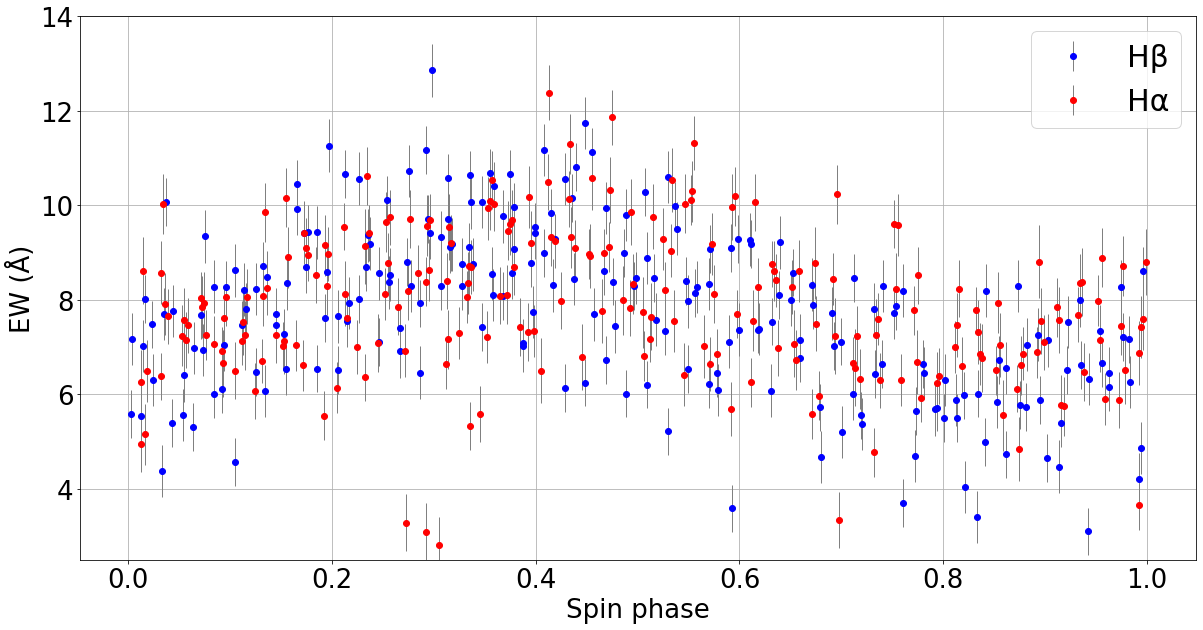

In [39]:
plt.figure(figsize=(20,10))
allBetaT = np.append(timeBJ,timeBM)
allBetaW = np.append(np.array(BJThree)*dwB,np.array(BMThree)*dwB)
allBettaErrors = np.append(BJThreeErrors, BMThreeErrors)

allAlphaT = np.append(timeRJ,timeRM)
allAlphaW = np.append(np.array(RJThree)*dwR,np.array(RMThree)*dwR)
allAlphaErrors = np.append(RJThreeErrors, RMThreeErrors)

phasesBeta = foldMeth(allBetaT,  0.08029820145279275)
sortIndi = np.argsort(phasesBeta)
phasesBeta = phasesBeta[sortIndi]
allBetaW = allBetaW[sortIndi]
allBettaErrors = allBettaErrors[sortIndi]

phasesAlpha = foldMeth(allAlphaT,  0.08029820145279275)
sortIndi = np.argsort(phasesAlpha)
phasesAlpha = phasesAlpha[sortIndi]
allAlphaW = allAlphaW[sortIndi]
allAlphaErrors = allAlphaErrors[sortIndi]

plt.errorbar(phasesBeta,allBetaW,yerr=allBettaErrors,c='b', lw=1, marker='o',ecolor='grey', ls = '', label='Hβ')

plt.errorbar(phasesAlpha,allAlphaW,yerr=allAlphaErrors,c='r', lw=1, marker='o',ecolor='grey', ls = '', label='Hα')
plt.ylim(2.5,14)
plt.legend(prop={'size': 30})
plt.ylabel('EW (Å)', fontsize=26)
plt.xlabel('Spin phase', fontsize=26)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid()
plt.savefig('EW-spinPhase.pdf')

In [44]:
(2.5/432)*100

0.5787037037037037